[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Pesos óptimos de la cartera:  [('TSLA', 20.150000000000002), ('^GSPC', 59.06), ('META', 20.79)]
Retorno óptimo de la cartera:  16.1112
Volatilidad óptima de la cartera:  24.0505
Ratio Sharpe óptimo de la cartera:  0.6699
Retorno óptimo de la cartera usando MonteCarlo  16.1211
Volatilidad óptima de la cartera usando MonteCarlo:  24.0652


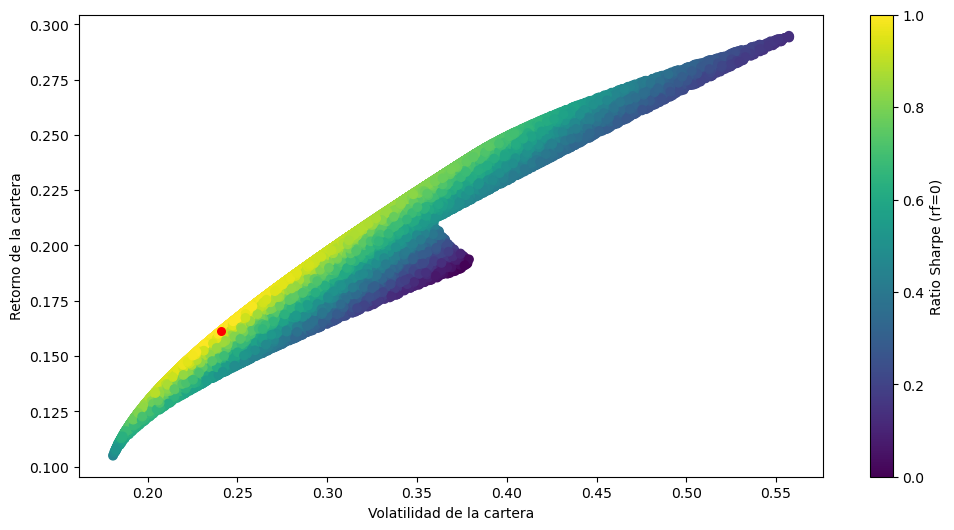

In [5]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import scipy.optimize as optimize
import sys

assets = tickers = ['TSLA','^GSPC', 'META']

data = pd.DataFrame()
for t in assets:
    data[t] = yf.download(t, start='2015-1-1')['Adj Close']

log_returns = np.log(1+data.pct_change())

port_returns = []
port_vols = []

for i in range (100000):
    num_assets = len(assets)
    weights = np.random.random(num_assets)
    weights /= np.sum(weights) 
    port_ret = np.sum(log_returns.mean() * weights) * 252
    port_var = np.sqrt(np.dot(weights.T, np.dot(log_returns.cov()*252, weights)))       
    port_returns.append(port_ret)
    port_vols.append(port_var)

def portfolio_stats(weights, log_returns):
    port_ret = np.sum(log_returns.mean() * weights) * 252
    port_var = np.sqrt(np.dot(weights.T, np.dot(log_returns.cov() * 252, weights)))
    sharpe = port_ret/port_var    
    return {'Return': port_ret, 'Volatility': port_var, 'Sharpe': sharpe}

def minimize_sharpe(weights, log_returns): 
    return -portfolio_stats(weights, log_returns)['Sharpe'] 

port_returns = np.array(port_returns)
port_vols = np.array(port_vols)
sharpe = port_returns/port_vols

max_sr_vol = port_vols[sharpe.argmax()]
max_sr_ret = port_returns[sharpe.argmax()]

constraints = ({'type' : 'eq', 'fun': lambda x: np.sum(x) -1})
bounds = tuple((0,1) for x in range(num_assets))
initializer = num_assets * [1./num_assets,]

optimal_sharpe = optimize.minimize(minimize_sharpe, initializer, method = 'SLSQP', args = (log_returns,) ,bounds = bounds, constraints = constraints)
optimal_sharpe_weights = optimal_sharpe['x'].round(4)
optimal_stats = portfolio_stats(optimal_sharpe_weights, log_returns)

print("Pesos óptimos de la cartera: ", list(zip(assets, list(optimal_sharpe_weights*100))))
print("Retorno óptimo de la cartera: ", round(optimal_stats['Return']*100,4))
print("Volatilidad óptima de la cartera: ", round(optimal_stats['Volatility']*100,4))
print("Ratio Sharpe óptimo de la cartera: ", round(optimal_stats['Sharpe'],4))

print("Retorno óptimo de la cartera usando MonteCarlo ", round(max_sr_ret*100,4))
print("Volatilidad óptima de la cartera usando MonteCarlo: ", round(max_sr_vol*100,4))

plt.figure(figsize = (12,6))
plt.scatter(port_vols,port_returns,c = (port_returns/port_vols))
plt.scatter(max_sr_vol, max_sr_ret,c='red', s=30)
plt.colorbar(label = 'Ratio Sharpe (rf=0)')
plt.xlabel('Volatilidad de la cartera')
plt.ylabel('Retorno de la cartera')
plt.show()